In [1]:
# Tested on python 3.6.4 
%matplotlib inline

import numpy as np # 1.13.3
from scipy.integrate import odeint # 1.0.0
import scipy.optimize as op
import scipy.stats as stats
import matplotlib.pyplot as plt # 2.1.1
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator

import pandas as pd # 0.22.0
import emcee # 2.2.1
import corner # 2.0.1
import progressbar # 3.34.3
import seaborn as sns # 0.8.1
from cycler import cycler # 0.10.0

print('emcee version', emcee.__version__)

# Directories defined here 
DIR_DATA = './data/'
DIR_PLOTS = './plots/'
DIR_OUT = './output/'

emcee version 2.2.1


This jupyter notebook analyses TXTL dynamics from the 2018 Swank et al. paper. The code in this notebook requires the following data files, which are located in `DIR_DATA`:

    dynamics_chip.csv
    dynamics_PR.csv
    
The results are used to generate Supplementary Figure S3. Plots are written into `DIR_PLOTS`.

In [2]:
def plotlin(data,name,DIR_PLOTS):

    plt.close("all")

    my_dpi=150

    figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. A5=8.27,5.83
    font_options={'size':'28','family':'sans-serif','sans-serif':'Arial'}
    plt.rc('figure', **figure_options)
    plt.rc('font', **font_options)

    current_palette=sns.color_palette("deep", 4)
    plt.rc('axes',prop_cycle=(cycler('color',current_palette)))
    f, axarr=plt.subplots()
    plt.subplots_adjust(left=0.25,bottom=0.2,right=0.95,top=0.95)
    
    # Plot data
    sns.regplot(x='init',y='fin',data=data,ci=95); 
    formatplot(axarr,'Initial rate (RFU/h)','Final level (RFU)', xlim=False,ylim=False)
    plt.savefig(DIR_PLOTS+name+'.pdf',dpi=my_dpi,transparent=True)

def plotlinPR(data,name,DIR_PLOTS):

    plt.close("all")

    my_dpi=150

    figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. A5=8.27,5.83
    font_options={'size':'28','family':'sans-serif','sans-serif':'Arial'}
    plt.rc('figure', **figure_options)
    plt.rc('font', **font_options)

    current_palette=sns.color_palette("deep", 4)
    plt.rc('axes',prop_cycle=(cycler('color',current_palette)))
    f, axarr=plt.subplots()
    plt.subplots_adjust(left=0.25,bottom=0.2,right=0.95,top=0.95)
    
    # Plot data
    sns.regplot(x='Initial Rate',y='Final Level',data=df2,ci=95);  
    formatplot(axarr,'Initial rate (RFU/h)','Final level (RFU)', xlim=False,ylim=False)
    plt.savefig(DIR_PLOTS+name+'.pdf',dpi=my_dpi,transparent=True)
    
def formatplot(ax,xlabel,ylabel,xlim,ylim,logx=False,logy=False,logxy=False,symlogx=False):

    ######### SET TITLES AND LABLES #########

    #ax.set_title('Plot title')
    if xlabel!=False:
        ax.set_xlabel(xlabel, labelpad=12)
    if ylabel!=False:    
        ax.set_ylabel(ylabel, labelpad=12)

    ######### SET AXES LIMITS #########

    if xlim!=False:
        ax.set_xlim(xlim)
    if ylim!=False:
        ax.set_ylim(ylim)

    ######### SET TICK VALUES #########

    #ax.set_xticks([0,0.5,1])
    #	ax.set_yticks([0,2,4,6,8])

    ######### SET LINE THICKNESSES #########

    #ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%1.e"))
    #ax.axhline(linewidth=2, color='k')      
    #ax.axvline(linewidth=2, color='k')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2) 

    ######### SET TICKS #########

    if logx==True:

        ax.set_xscale("log")

    elif logy==True:

        ax.set_yscale("log")

    elif logxy==True:

        ax.set_xscale("log")
        ax.set_yscale("log")
    
    elif symlogx==True:

        ax.set_xscale("symlog",linthreshx=1e-4)
        ax.set_yscale("log")

    else:
        minorLocatorx=AutoMinorLocator(2) # Number of minor intervals per major interval
        minorLocatory=AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minorLocatorx)
        ax.yaxis.set_minor_locator(minorLocatory)

    ax.tick_params(which='major', width=2, length=8, pad=9,direction='in',top='on',right='on')
    ax.tick_params(which='minor', width=2, length=4, pad=9,direction='in',top='on',right='on')

Our thermodynamic models calculate RNAP occupancies, and the validity of their comparisons with experiments relies on the proportionality between occupancy, transcription rate, and translation rate:

\begin{equation}
y=Ap_{bound}.
\end{equation}

In our experiments we measure dynamic GFP production, but generally report only the final level. We can check to ensure that the final level (whose value is determined by cell-free exhaustion) is related to the initial GFP production rate (which is proportional to translation rate). A linear relationship between the two quantities would validate our use of final levels (and fold repressions calculated from those quantities) as a proxy to measure translation rate. 

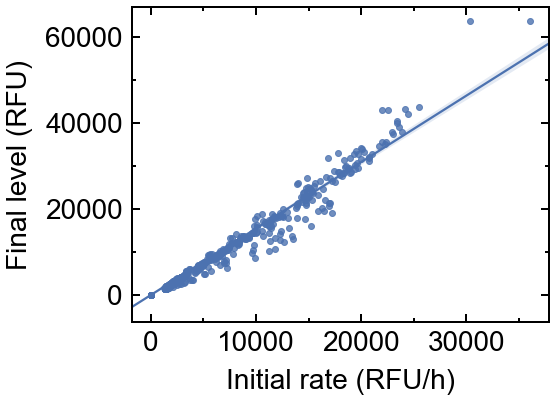

In [3]:
# Load timecourse data
df=pd.read_csv('data/dynamics_chip.csv',delimiter=',')

# Plot timecourse data
init=np.zeros(df.shape[0]*(df.shape[1]-1))
fin=np.zeros(df.shape[0]*(df.shape[1]-1))

d={'init': init, 'fin': fin}
dataF=pd.DataFrame(data=d)
i=0
for k in range((df.shape[1]-1)):    
    dataF['init'].iloc[i]=df.iloc[1,k+1]/df.iloc[1,0]*60
    dataF['fin'].iloc[i]=df.iloc[-1,k+1]
    i+=1

# Uncomment this to look at time courses
#f,ax=plt.subplots()
#i=0
#for k in range((df.shape[1]-1)):    
#    ax.plot(df.iloc[:,0],df.iloc[:,k+1],'o-');
#    dataF['init'].iloc[i]=df.iloc[1,k+1]/df.iloc[1,0]*60
#    dataF['fin'].iloc[i]=df.iloc[-1,k+1]
#    i+=1
#plt.show()

plotlin(dataF,'rates_timecoursechip',DIR_PLOTS)

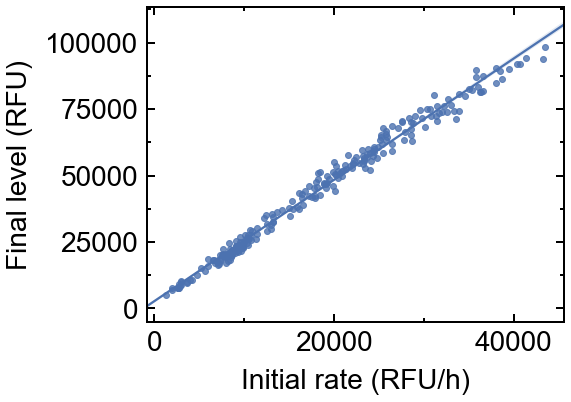

In [4]:
# Load and plot plate reader ZF data (orthogonality matrix)
df2=pd.read_csv(DIR_DATA+'dynamics_PR.csv',delimiter=',')
plotlinPR(df2,'rates_PR',DIR_PLOTS)

We observe a linear relationship between initial rates and final levels both on the plate reader as well as on chip, thus validating our use of the final level as a proxy for translation rate.